In [213]:
import pennylane as qml
from pennylane import qaoa
from pennylane import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
import jax
import jax.numpy as jnp
import seaborn as sns

In [183]:
N = 1
M = 3

In [245]:
wires = range(N + M)
dev = qml.device("default.qubit", wires=wires)
ctrl = M

@qml.qnode(dev, interface="jax")
def gen_state(g, f):
    qml.Hadamard(0)
    for w in range(N, N + M):
        qml.Hadamard(wires=w)
    for i in range(M):
        qml.ControlledPhaseShift(2 ** i * (g), [0, N+i])
    qftidx = list(reversed(range(N, N+M)))
    qml.adjoint(qml.QFT(wires=qftidx))

    qml.PauliX(ctrl)
    qml.ControlledPhaseShift(f, wires=[0, ctrl])
    qml.PauliX(ctrl)
   
    qml.QFT(wires=qftidx)
    for i in range(M):
        qml.ControlledPhaseShift(-2 ** i * (g), [0, N+i])
    for w in range(N, N + M):
        qml.Hadamard(wires=w)
    return qml.state()

In [185]:
# print(qml.draw(gen_state)(0.3, 0.1))

In [246]:
def nv_get_f(g, f):
    res = gen_state(g, f)
    state = res[::2 ** M]
    return state[1]

get_f = jax.jit(jax.vmap(nv_get_f))

In [247]:
x = np.linspace(-np.pi, np.pi, 1000)
y = x

X, Y = np.meshgrid(x, y)

In [248]:
clp = sns.color_palette("husl", as_cmap=True)

In [250]:
def colorize(Z):
    f = clp(jax.numpy.angle(Z) / (2 * np.pi) + 0.5)
    print(f.shape)
    f[:, :, :3] *= jax.numpy.abs(Z)[:, :, None]
    return f

In [251]:
Z = get_f(X.ravel(), Y.ravel())
Z = Z.reshape(X.shape)

(1000, 1000, 4)


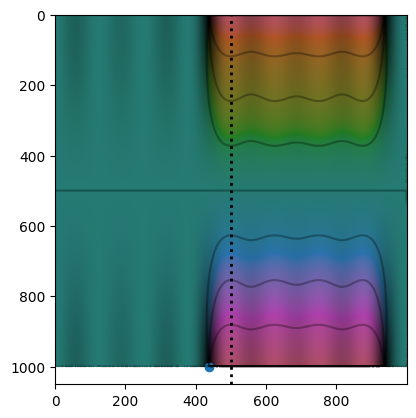

In [252]:
plt.imshow(colorize(Z))
plt.contour(np.angle(Z), colors="k", linestyles="solid", alpha=0.3)
plt.axvline(x=500, color="k", linewidth=2, linestyle="dotted")
plt.scatter((-np.pi / (2 ** M) + np.pi) / (2 * np.pi) * 1000, (np.pi + np.pi) / (2 * np.pi) * 1000)

In [253]:
X.shape

(1000, 1000)

In [254]:
def nv_abs(f, g):
    res = gen_state(g, f)
    state = res[::2 ** M]
    state /= jnp.sqrt((jnp.abs(state)**2).sum())
    return jnp.abs(state[1]) ** 2

In [255]:
func = jax.vmap(jax.grad(nv_abs))

In [256]:
T = func(X.ravel(), Y.ravel()).reshape(X.shape)

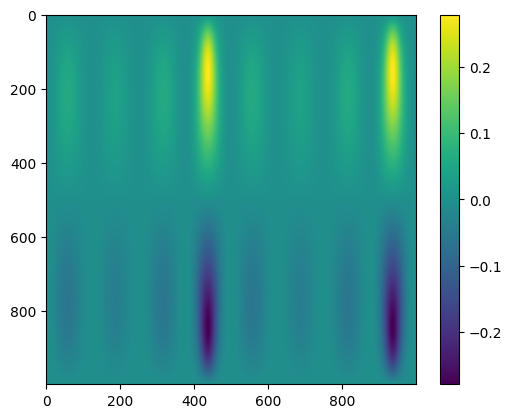

In [257]:
x = plt.imshow(T.T)
plt.colorbar(x)

In [211]:
np.fft.fft(np.linspace(0, 1, 1 << 25))

tensor([ 1.67772160e+07      +0.j        ,
        -5.00000015e-01+5340353.8745958j ,
        -5.00000015e-01+2670176.93729788j, ...,
        -5.00000015e-01-1780117.95819856j,
        -5.00000015e-01-2670176.93729788j,
        -5.00000015e-01-5340353.8745958j ], requires_grad=True)